# Analýza sentimentu - semestrální práce

Tato semestrální práce se zabývá zpracováním úlohy analýzy sentimentu na vybraném datasetu za použití knihovny NLTK (Natural Language Toolkit). Cílem práce je otestovat možnosti této knihovny a využít její prostředky pro danou úlohu. V rámci práce budou vyzkoušeny různé techniky pro zpracování analýzy sentimentu a na závěr budou tyto výsledky porovnány z hlediska vhodné metriky.

Jako dataset byl zvolen IMDB Movie Ratings, tedy recenze filmů a seriálů z platformy IMDB.

- Autor: David Poslušný
- Knihovna: https://www.nltk.org/
- Dataset: https://www.kaggle.com/datasets/yasserh/imdb-movie-ratings-sentiment-analysis

### Import knihoven

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import re
import random

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet, sentiwordnet
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
from nltk.probability import FreqDist
from nltk.metrics import accuracy
from nltk.classify import NaiveBayesClassifier
from nltk.classify.scikitlearn import SklearnClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

import gensim
from gensim.models import Word2Vec

from transformers import BertTokenizer
from transformers.tokenization_utils_base import BatchEncoding
from transformers import BertModel

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from pandas.core.reshape.encoding import DataFrame

from torch.optim import Adam
from tqdm import tqdm

### Příprava souborů

- **stopwods** - slovník stop slov nutný pro lingvistické předzpracování
- **punkt** - předtrénovaný punkt tokenizer, který slouží jako oddělovač vět
- **wordnet** - anglická lexikální databáze WordNet
- **vader_lexicon** - NLTK analyzátor sentimentu založený na pravidlech
- **sentiwordnet** - SentiWordNet je lexikální zdroj pro opinion mining
- **averaged_perceptron_tagger** - předtrénovaný POS tagger

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('sentiwordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

### Import dat

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
datapath = '/content/drive/MyDrive/4IZ470/sentiment/movie.csv'
data = pd.read_csv(datapath)

## 1 Průzkum dat

V této kapitole provedeme průzkum dat.

In [ ]:
data.head(10)

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1
5,A terrible movie as everyone has said. What ma...,0
6,Finally watched this shocking movie last night...,1
7,I caught this film on AZN on cable. It sounded...,0
8,It may be the remake of 1987 Autumn's Tale aft...,1
9,My Super Ex Girlfriend turned out to be a plea...,1


Dataset má 2 sloupce: text a label. Text označuje text recenze a label značí hodnotu sentimentu. 1 znamená pozitivní sentiment a 0 znamená negativní sentiment.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


Dataset má celkem 40 000 řádků.

In [ ]:
data.shape

(40000, 2)

In [ ]:
data.isna().sum()

text     0
label    0
dtype: int64

Dataset nemá žádné chybějící hodnoty, není tedy nutné provést tento typ předzpracování.

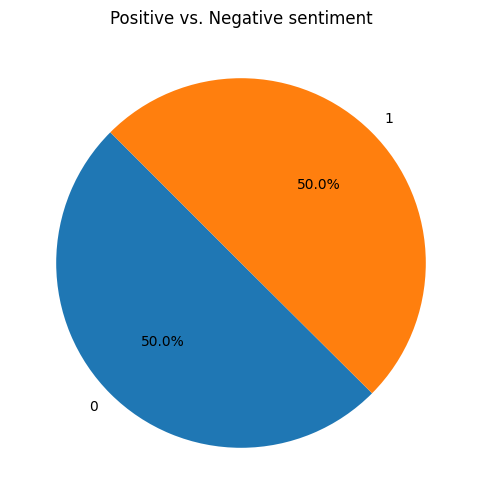

In [ ]:
sentiments = data['label'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(
  sentiments,
  labels=sentiments.index,
  autopct='%1.1f%%',
  startangle=135
  )
plt.title('Positive vs. Negative sentiment')
plt.show()

Výsečový graf nám ukazuje, že poměr pozitivního a negativního sentimentu je 50 %. Dataset tedy lze považovat za vybalancovaný.

In [ ]:
positive_reviews = data[data['label'] == 1]
negative_reviews = data[data['label'] == 0]

In [ ]:
print('Number of positive sentiments:', sentiments[1])
print('Number of negative sentiments: ', sentiments[0])

Number of positive sentiments: 19981
Number of negative sentiments:  20019


Recenze jsou často dlouhé, obsahují i třeba přes 1000 slov, proto nyní velikost datasetu snížíme na polovinu, aby bylo trénování modelů rychlejší a splnitelné v přiměřeném čase, zejména pro model BERT. Důležité je zde zachovat poměr 1:1 mezi sentimentem, abychom dostali reprezentativní výsledky.

In [ ]:
sample_positive = positive_reviews.sample(n=10000, random_state=42)
sample_negative = negative_reviews.sample(n=10000, random_state=42)

In [ ]:
reviews = pd.concat([sample_positive, sample_negative])
reviews = reviews.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
reviews.shape

(20000, 2)

In [ ]:
reviews['label'].value_counts()

label
0    10000
1    10000
Name: count, dtype: int64

Nyní máme 10 000 pozitivních recenzí a 10 000 negativních recenzí. Můžeme tedy přejít na předzpracování datasetu.

## 2. Předzpracování dat

V této kapitole provedeme lingvistické a textové předzpracování textových dat.

Zde vidíme příklad toho jak vypadají recenze.

In [ ]:
print(reviews['text'][123])

I really enjoyed this -- I'm a big fan of movies that mess with your mind and leave you with a lot of questions and ideas to debate, and this was a stellar example. But then, Terry Gilliam is always good at that (well, almost always. Let's just forget about Jabberwocky and The Brothers Grimm, shall we?).<br /><br />I particularly liked the way it handled the time travel theme and the avoidance of paradoxes -- the way events in the past and future intertwined and fed into each other.<br /><br />It was also really well done aesthetically -- the art direction was really great, and I wish I'd been able to see it on the big screen. The future scenes had a similar feel to Brazil in a lot of ways, and even the present scenes were often really visually compelling.<br /><br />But perhaps the most striking thing about it was that it featured two actors I normally don't much like, Bruce Willis and Brad Pitt, and they both delivered amazing performances here. Pitt especially -- I'd seen one or two

V rámci předzpracování provedeme:
- **odstranění HTML značek** - značky jako \<p> a \<br> se objevují v textech
- **tokenizace** - označení slov a mezer + identifikace vět
- **odstranění stop slov** - odstranění bezvýznamných slov
- **odstranění diakritiky**
- **odstranění non-alfanumerických slov**
- **lemmatizace** - převod slov na jejich základní tvar

Pro lemmatizaci využijeme WordNet lemmatizátor přímo obsažený v knihovně NLTK.
Jedná se o lemmatizaci pomocí vestavěné morfické funkce WordNetu.

V rámci stop slov vybereme slovník pouze pro anglický jazyk.

In [ ]:
lemmatizer = WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english')

pattern_html = r'<.*?>'

def preprocess_text(text):

  text = re.sub(pattern_html, '', text)

  tokens = word_tokenize(text.lower())

  tokens_filtered = [token for token in tokens if token not in stopwords]

  tokens_filtered = [token for token in tokens_filtered if token not in string.punctuation]

  tokens_filtered = [token for token in tokens_filtered if token.isalpha()]

  tokens_lemmatized = [lemmatizer.lemmatize(token) for token in tokens_filtered]

  preprocessed_text = ' '.join(tokens_lemmatized)

  return preprocessed_text

Na konec předzpracované tokeny opět spojíme a vrátíme jako jeden řetězec.

Tuto pipeline nyní aplikujeme na všechny recenze v datasetu.

In [ ]:
reviews['text'] = reviews['text'].apply(preprocess_text)

Nyní se lze podívat na předzpracovaný text.

In [ ]:
reviews['text'][123]

'really enjoyed big fan movie mess mind leave lot question idea debate stellar example terry gilliam always good well almost always let forget jabberwocky brother grimm shall particularly liked way handled time travel theme avoidance paradox way event past future intertwined fed also really well done aesthetically art direction really great wish able see big screen future scene similar feel brazil lot way even present scene often really visually perhaps striking thing featured two actor normally much like bruce willis brad pitt delivered amazing performance pitt especially seen one two film made realize could fact actually act contrary originally thought one really outdid actually found asking friend one point sure brad pitt probably memorable performance career though admittedly may saying much'

## 3. Analýza sentimentu pomocí slovníkových metod

V této kapitole využijeme dvě metody pro analýzy sentimentu z knihovny NLTK: VADER a SentiWordNet. Jedná se slovníkové metody založené na pravidlech.

### 3.1 VADER

VADER (Valence Aware Dictionary and Sentiment Reasoner) je lexikon a nástroj pro analýzu sentimentu založený na pravidlech. Používá předdefinovaný lexikon, kde jednotlivá slova mají přiřazené skóre sentimentu.

https://www.nltk.org/_modules/nltk/sentiment/vader.html

In [ ]:
reviews_vader = reviews.copy()

Vytvoříme instanci VADER, která bude pro každou recenzi vracet normalizované skóre od -1 do 1. Pozitivní hodnoty znační kladnou valenci a negativní hodnoty značí negativní valenci.

https://www.nltk.org/_modules/nltk/sentiment/sentiment_analyzer.html

Prahová hodnota pro klasifikaci je 0.

In [ ]:
vader = SentimentIntensityAnalyzer()

def get_sentiment_vader(text):
    scores = vader.polarity_scores(text)

    threshhold = 0

    if scores['compound'] > threshhold:
        return 1
    else:
        return 0

In [ ]:
reviews_vader['prediction'] = reviews_vader['text'].apply(get_sentiment_vader)

Nyní provedeme evaluaci této metody. Spočítáme správnost a vizualizujeme také matici záměn.

In [ ]:
print(accuracy(reviews_vader['label'], reviews_vader['prediction']))

0.6736


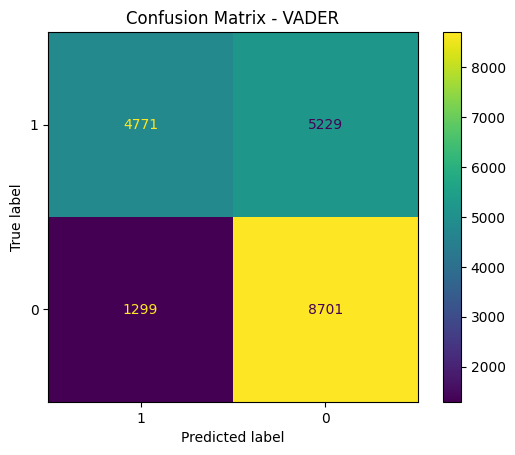

In [ ]:
ConfusionMatrixDisplay.from_predictions(
  reviews_vader['label'],
  reviews_vader['prediction'],
  display_labels=[1, 0]
  )
plt.title('Confusion Matrix - VADER')
plt.show()

### 3.2 SentiWordNet

SentiWordNet je lexikální zdroj pro opining mining. SentiWordNet přiřazuje každému synsetu WordNetu tři skóre sentimentu: pozitivitu, negativitu nebo objektivitu.

https://www.nltk.org/_modules/nltk/corpus/reader/sentiwordnet.html

In [ ]:
reviews_swn = reviews.copy()

Na začátek si vytvoříme funkci, která převádí tagy z formátu Penn Treebank (defaultně používané v knihovně NLTK) na WordNet tagy, jelikož budeme pracovat s lexikální databází WordNet.

In [ ]:
def penn_to_wn(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

Nyní vytvoříme funkci, která spočítá skóre recenze pomocí lexikonu WordNet.


Každou recenzi tokenizujeme a pro každý token určíme slovní druh (POS tagging). Po převedení tagů na WordNet tagy se pro každý token získají synsety z WordNetu.

Každé slovo může mít více synsetů (synonym) a tak se vždy vybere pouze ten první, který je v rámci hierarchie nejpravděpodobnější význam daného slova.

Pro vybraný výraz se spočítá jeho sentiment skóre jako rozdíl mezi pozitivním a negativním skórem.

Tento proces poté opakujeme pro každé slovo každé recenze.

In [ ]:
def get_sentiment_sentiwordnet(text):
    tokens = word_tokenize(text)
    tokens_tagged = pos_tag(tokens)

    sentiment_score = 0
    count = 0

    for word, tag in tokens_tagged:
        wn_tag = penn_to_wn(tag)
        if not wn_tag:
            continue

        synsets = wordnet.synsets(word, pos=wn_tag)
        if not synsets:
            continue

        synset = synsets[0]
        swn_synset = sentiwordnet.senti_synset(synset.name())

        sentiment_score += swn_synset.pos_score() - swn_synset.neg_score()
        count += 1

    if count == 0:
        return 0
    else:
        return sentiment_score / count

In [ ]:
reviews_swn['prediction'] = reviews_swn['text'].apply(get_sentiment_sentiwordnet)

Na základě získané kumulativní predikce ze všech slov textu se nyní provede klasifikace buď jako pozitivní nebo negativní sentiment pro celou recenzi.

In [ ]:
def classify_prediction(score):
  if score > 0:
    return 1
  else:
    return 0

In [ ]:
reviews_swn['predicted_label'] = reviews_swn['prediction'].apply(classify_prediction)

Nyní provedeme evaluaci této metody. Spočítáme správnost a vizualizujeme také matici záměn.

In [ ]:
print(accuracy(reviews_swn['label'], reviews_swn['predicted_label']))

0.6367


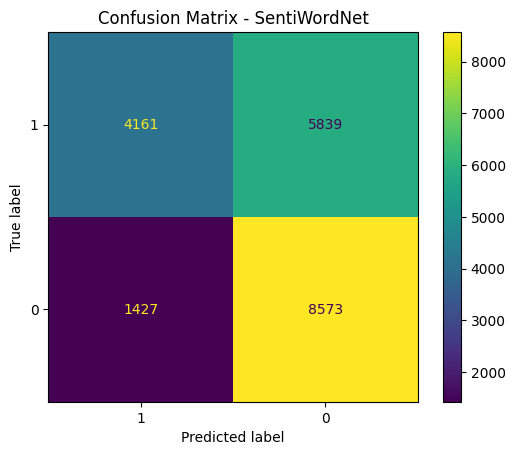

In [ ]:
ConfusionMatrixDisplay.from_predictions(
  reviews_swn['label'],
  reviews_swn['predicted_label'],
  display_labels=[1, 0]
  )
plt.title('Confusion Matrix - SentiWordNet')
plt.show()

## 4. Feature Extraction

V této kapitole provedeme pomocí různých metod extrakci rysů , které jsou nezbytné pro učení machine learning klasifikátorů.

Recenze a jejich sentimenty převedeme do podoby listu pro další práci.

In [ ]:
documents = [(list(word_tokenize(review)), label) for review, label in zip(reviews['text'], reviews['label'])]
random.shuffle(documents)

Pomocí funkce `FreqDist()` vytvoříme slovník pro náš dataset, který bude obsahovat všechna unikátní slova, která se v něm vyskytují.



https://www.nltk.org/api/nltk.probability.FreqDist.html

In [ ]:
all_words = FreqDist(w.lower() for review in reviews['text'] for w in word_tokenize(review))

Nyní si můžeme nechat vypsat 10 nejčastějších slov.

In [ ]:
all_words.most_common(n=10)

[('movie', 39857),
 ('film', 35857),
 ('one', 21165),
 ('like', 16116),
 ('time', 11953),
 ('good', 11592),
 ('character', 11088),
 ('would', 10520),
 ('get', 9981),
 ('even', 9884)]

Jelikož se jedná o filmové recenze, vidíme, že slova jako 'movie' a 'film' se v textech objevují nejvíce.

Dále je možné zjistit frekvence pro jednotlivá slova.

In [ ]:
print(all_words['love'])
print(all_words['terrible'])
print(all_words['character'])
print(all_words['plot'])
print(all_words['banana'])

5467
1307
11088
5233
37


In [ ]:
print("Vocabulary size:", len(all_words))

Vocabulary size: 60645


### 4.1 Unigram

Jako první z textů extrahujeme unigramy.

Pro každý dokument se extrahují všechna jeho slova a jejich frekvence v textu.

In [ ]:
def document_unigram_features(document):
    unigrams = {}
    for token in document:
        if token in unigrams:
            unigrams[token] += 1
        else:
            unigrams[token] = 1
    return unigrams

In [ ]:
features_uni = [(document_unigram_features(d), c) for (d, c) in documents]

### 4.2 Bigram

Dále extrahujeme stejným způsobem bigramy, tedy dvojice slov. V tomto případě si pomůžeme nástrojem z knihovny NLTK na extrakci slovních bigramů.

https://www.nltk.org/api/nltk.collocations.BigramCollocationFinder.html

In [ ]:
def document_bigram_features(document):
    bigrams = {}
    bigram_finder = BigramCollocationFinder.from_words(document)
    for bigram, freq in bigram_finder.ngram_fd.items():
      bigrams[bigram] = freq
    return bigrams

In [ ]:
features_bi = [(document_bigram_features(d), c) for (d, c) in documents]

### 4.3 Trigram

Nyní obdobně extrahujeme trigramy, tedy trojice slov.

https://www.nltk.org/api/nltk.collocations.TrigramCollocationFinder.html

In [ ]:
def document_trigram_features(document):
    trigrams = {}
    trigram_finder = TrigramCollocationFinder.from_words(document)
    for trigram, freq in trigram_finder.ngram_fd.items():
      trigrams[trigram] = freq
    return trigrams

In [ ]:
features_tri = [(document_trigram_features(d), c) for (d, c) in documents]

### 4.4 Word2Vec

Na konec pomocí knihovny Gensim extrahujeme vektory slovních vnoření pomocí algoritmu Word2Vec.

In [ ]:
tokenized_text = [word_tokenize(review) for review in reviews['text']]

https://radimrehurek.com/gensim/models/word2vec.html

V tomto případě se jedná o vektor s 300 dimenzemi a CBOW přístupem. Model se bude trénovat 20 epoch.

In [ ]:
EMBEDDING_DIM = 300
EPOCHS = 20
WINDOW_SIZE = 5
MIN_COUNT = 1
SG = 0

w2v_model = Word2Vec(
  tokenized_text,
  vector_size=EMBEDDING_DIM,
  window=WINDOW_SIZE,
  min_count=MIN_COUNT,
  sg=SG,
  epochs=EPOCHS
  )

Funkce, která z modelu extrahuje vektory vnoření pro jednotlivé dokumenty.

In [ ]:
def get_word_embeddings(document, model):
  embeddings = []
  for word in document:
    if word in model.wv.key_to_index:
      embeddings.append(model.wv[word])
    return embeddings

Funkce, která převede vektor vnoření do podoby, která je akceptována NLTK klasifikátory.

In [ ]:
def document_w2v_features(document):
  features = {}
  word_embeddings = get_word_embeddings(document, w2v_model)
  if word_embeddings:
    embeddings = np.mean(word_embeddings, axis=0)
    for idx, value in enumerate(embeddings):
      features[f'dim_{idx}'] = value
  return features

In [ ]:
features_w2v = [(document_w2v_features(d), c) for (d, c) in documents]

## 5. Analýza sentimentu pomocí klasifikátorů

V této kapitole provedeme analýzu sentimentu pomocí klasifikátorů strojového učení:
- naivní bayesovský klasifikátor
- logistická regrese
- support vector machines

Jelikož se jedná o modely, které se učí vzory, je v tomto případě nutné data rozdělit na trénovací a testovací množinu. Data rozdělíme v podílu 80/20.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [ ]:
train_set_uni, test_set_uni = train_test_split(features_uni, test_size=0.2, random_state=123, shuffle=True)
train_set_bi, test_set_bi = train_test_split(features_bi, test_size=0.2, random_state=123, shuffle=True)
train_set_tri, test_set_tri = train_test_split(features_tri, test_size=0.2, random_state=123, shuffle=True)
train_set_w2v, test_set_w2v = train_test_split(features_w2v, test_size=0.2, random_state=123, shuffle=True)

Pro evaluace modelů si také extrahujeme skutečné hodnoty sentimentů.

In [ ]:
uni_test_true = [label for (features, label) in test_set_uni]
bi_test_true = [label for (features, label) in test_set_bi]
tri_test_true = [label for (features, label) in test_set_tri]
w2v_test_true = [label for (features, label) in test_set_w2v]

### 5.1 Naive Bayes

Naivní Bayesovy metody jsou souborem algoritmů učení s dohledem založených na použití Bayesovy věty s naivní předpokladem podmíněné nezávislosti mezi každou dvojicí rysů danou hodnotou proměnné třídy.

https://www.nltk.org/_modules/nltk/classify/naivebayes.html

#### 5.1.1 Unigrams

In [ ]:
nb_uni = NaiveBayesClassifier.train(train_set_uni)
nb_uni_pred = [nb_uni.classify(features) for (features, label) in test_set_uni]

In [ ]:
print(round(accuracy(uni_test_true, nb_uni_pred), 4))

0.8413


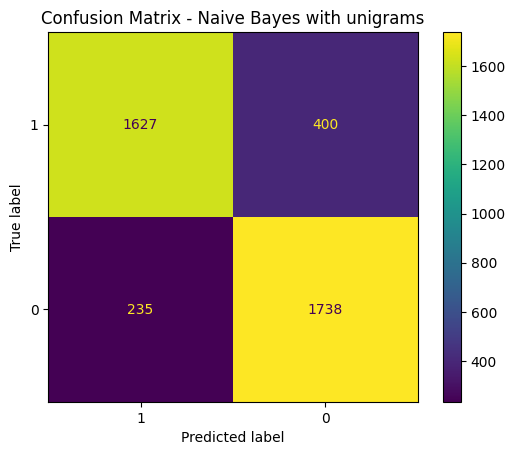

In [ ]:
ConfusionMatrixDisplay.from_predictions(
    uni_test_true,
    nb_uni_pred,
    display_labels=[1, 0]
    )
plt.title('Confusion Matrix - Naive Bayes with unigrams')
plt.show()

#### 5.1.2 Bigrams

In [ ]:
nb_bi = NaiveBayesClassifier.train(train_set_bi)
nb_bi_pred = [nb_bi.classify(features) for (features, label) in test_set_bi]

In [ ]:
print(round(accuracy(bi_test_true, nb_bi_pred), 4))

0.8518


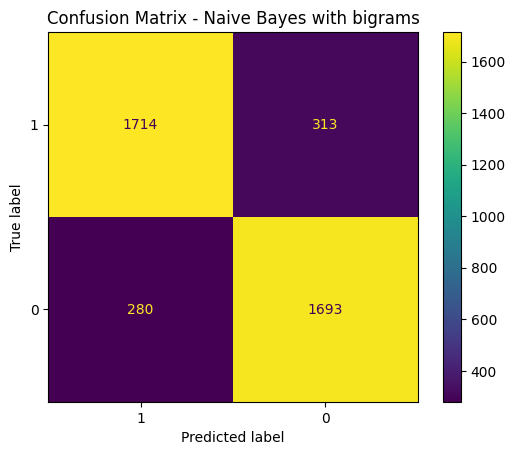

In [ ]:
ConfusionMatrixDisplay.from_predictions(
    bi_test_true,
    nb_bi_pred,
    display_labels=[1, 0]
    )
plt.title('Confusion Matrix - Naive Bayes with bigrams')
plt.show()

#### 5.1.3 Trigrams

In [ ]:
nb_tri = NaiveBayesClassifier.train(train_set_tri)
nb_tri_pred = [nb_tri.classify(features) for (features, label) in test_set_tri]

In [ ]:
print(round(accuracy(tri_test_true, nb_tri_pred), 4))

0.7438


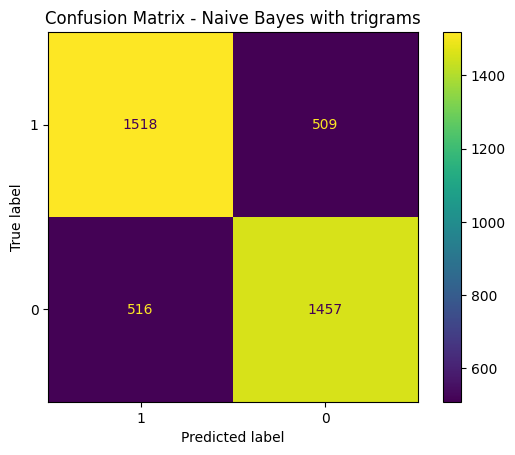

In [ ]:
ConfusionMatrixDisplay.from_predictions(
    tri_test_true,
    nb_tri_pred,
    display_labels=[1, 0]
    )
plt.title('Confusion Matrix - Naive Bayes with trigrams')
plt.show()

#### 5.1.4 Word Embeddings

In [ ]:
nb_w2v = NaiveBayesClassifier.train(train_set_w2v)
nb_w2v_pred = [nb_w2v.classify(features) for (features, label) in test_set_w2v]

In [ ]:
print(round(accuracy(w2v_test_true, nb_w2v_pred), 4))

0.577


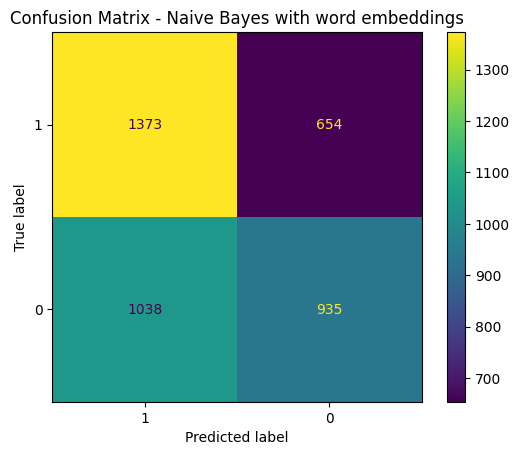

In [ ]:
ConfusionMatrixDisplay.from_predictions(
    w2v_test_true,
    nb_w2v_pred,
    display_labels=[1, 0]
    )
plt.title('Confusion Matrix - Naive Bayes with word embeddings')
plt.show()

### 5.2 Logistic Regression

Logistická regrese odhaduje pravděpodobnost výskytu určité události, například že respondent volil nebo nevolil, na základě daného souboru nezávislých proměnných.

https://www.nltk.org/api/nltk.classify.scikitlearn.html

#### 5.2.1 Unigrams

In [ ]:
lr_uni = SklearnClassifier(LogisticRegression(max_iter=1000)).train(train_set_uni)
lr_uni_pred = [lr_uni.classify(features) for (features, label) in test_set_uni]

In [ ]:
print(round(accuracy(uni_test_true, lr_uni_pred), 4))

0.8778


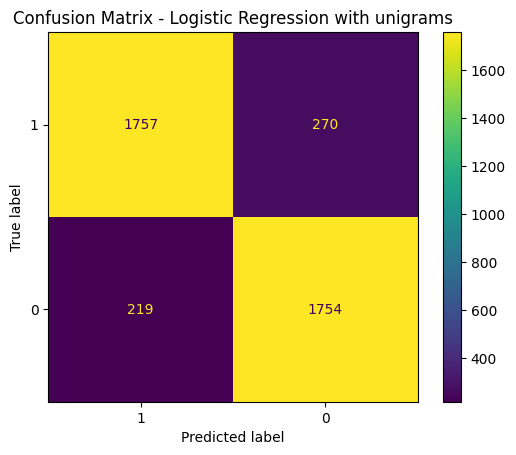

In [ ]:
ConfusionMatrixDisplay.from_predictions(
    uni_test_true,
    lr_uni_pred,
    display_labels=[1, 0]
    )
plt.title('Confusion Matrix - Logistic Regression with unigrams')
plt.show()

#### 5.2.2 Bigrams

In [ ]:
lr_bi = SklearnClassifier(LogisticRegression(max_iter=1000)).train(train_set_bi)
lr_bi_pred = [lr_bi.classify(features) for (features, label) in test_set_bi]

In [ ]:
print(round(accuracy(bi_test_true, lr_bi_pred), 4))

0.835


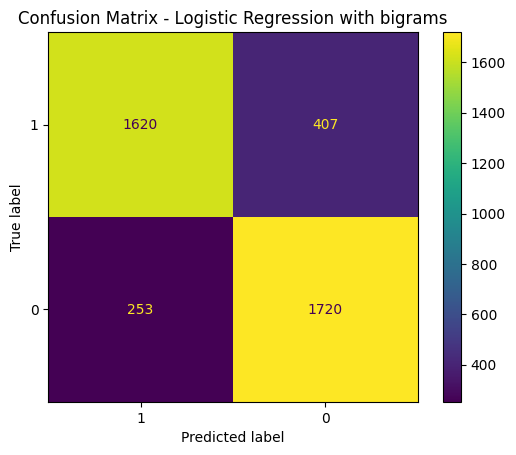

In [ ]:
ConfusionMatrixDisplay.from_predictions(
    bi_test_true,
    lr_bi_pred,
    display_labels=[1, 0]
    )
plt.title('Confusion Matrix - Logistic Regression with bigrams')
plt.show()

#### 5.2.3 Trigrams

In [ ]:
lr_tri = SklearnClassifier(LogisticRegression(max_iter=1000)).train(train_set_tri)
lr_tri_pred = [lr_tri.classify(features) for (features, label) in test_set_tri]

In [ ]:
print(round(accuracy(tri_test_true, lr_tri_pred), 4))

0.696


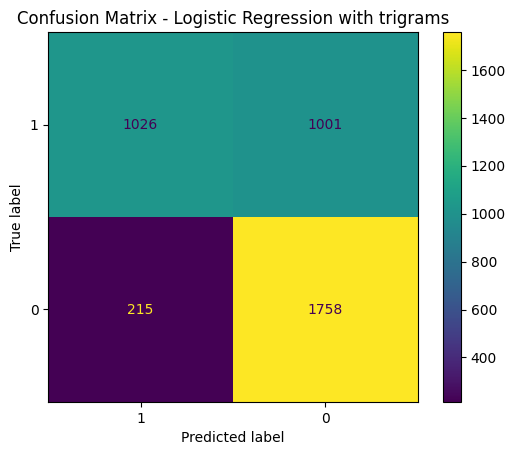

In [ ]:
ConfusionMatrixDisplay.from_predictions(
    tri_test_true,
    lr_tri_pred,
    display_labels=[1, 0]
    )
plt.title('Confusion Matrix - Logistic Regression with trigrams')
plt.show()

#### 5.2.4 Word Embeddings

In [ ]:
lr_w2v = SklearnClassifier(LogisticRegression(max_iter=1000)).train(train_set_w2v)
lr_w2v_pred = [lr_w2v.classify(features) for (features, label) in test_set_w2v]

In [ ]:
print(round(accuracy(tri_test_true, lr_tri_pred), 4))

0.696


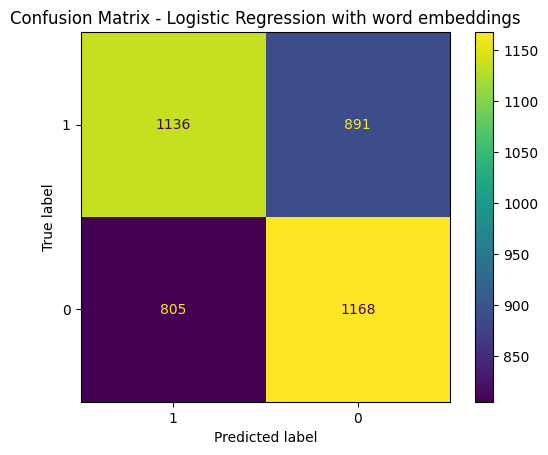

In [ ]:
ConfusionMatrixDisplay.from_predictions(
    w2v_test_true,
    lr_w2v_pred,
    display_labels=[1, 0]
    )
plt.title('Confusion Matrix - Logistic Regression with word embeddings')
plt.show()

### 5.3 Support Vector Machines

Support Vector Machine (SVM) jsou sadou supervised learning metod, které se používají pro klasifikaci, regresi a detekci odlehlých hodnot.

V tomto případě budeme používat LinearSVC, což je lineární varianta SVM.

https://www.nltk.org/api/nltk.classify.scikitlearn.html

#### 5.3.1 Unigrams

In [ ]:
svc_uni = SklearnClassifier(LinearSVC(max_iter=10000)).train(train_set_uni)
svc_uni_pred = [svc_uni.classify(features) for (features, label) in test_set_uni]

In [ ]:
print(round(accuracy(uni_test_true, svc_uni_pred), 4))

0.862


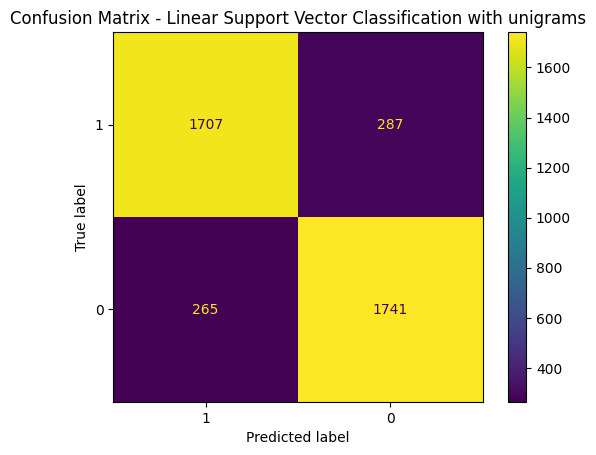

In [ ]:
ConfusionMatrixDisplay.from_predictions(
    uni_test_true,
    svc_uni_pred,
    display_labels=[1, 0]
    )
plt.title('Confusion Matrix - Linear Support Vector Classification with unigrams')
plt.show()

#### 5.3.2 Bigrams

In [ ]:
svc_bi = SklearnClassifier(LinearSVC(max_iter=10000)).train(train_set_bi)
svc_bi_pred = [svc_bi.classify(features) for (features, label) in test_set_bi]

In [ ]:
print(round(accuracy(bi_test_true, svc_bi_pred), 4))

0.8335


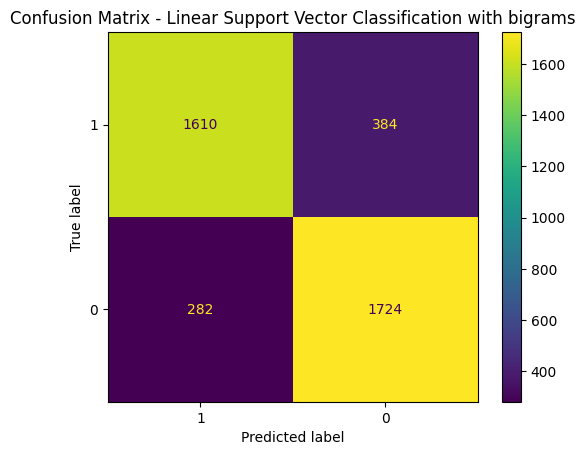

In [ ]:
ConfusionMatrixDisplay.from_predictions(
    bi_test_true,
    svc_bi_pred,
    display_labels=[1, 0]
    )
plt.title('Confusion Matrix - Linear Support Vector Classification with bigrams')
plt.show()

#### 5.3.3 Trigrams

In [ ]:
svc_tri = SklearnClassifier(LinearSVC(max_iter=10000)).train(train_set_tri)
svc_tri_pred = [svc_tri.classify(features) for (features, label) in test_set_tri]

In [ ]:
print(round(accuracy(tri_test_true, svc_tri_pred), 4))

0.7105


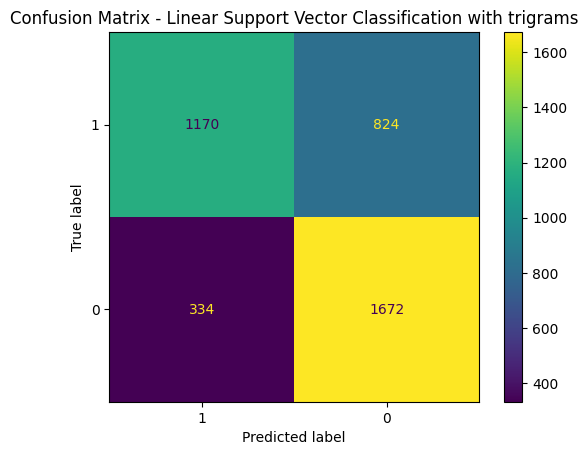

In [ ]:
ConfusionMatrixDisplay.from_predictions(
    tri_test_true,
    svc_tri_pred,
    display_labels=[1, 0]
    )
plt.title('Confusion Matrix - Linear Support Vector Classification with trigrams')
plt.show()

#### 5.3.4 Word Embeddings

In [ ]:
svc_w2v = SklearnClassifier(LinearSVC(max_iter=10000)).train(train_set_w2v)
svc_w2v_pred = [svc_w2v.classify(features) for (features, label) in test_set_w2v]

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
print(round(accuracy(w2v_test_true, svc_w2v_pred), 4))

0.5865


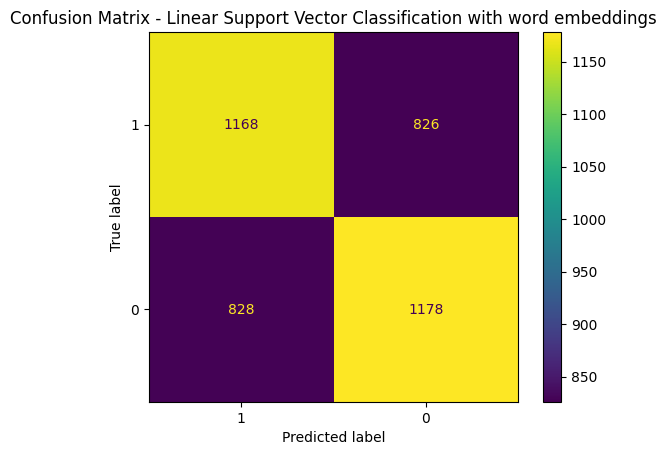

In [ ]:
ConfusionMatrixDisplay.from_predictions(
    w2v_test_true,
    svc_w2v_pred,
    display_labels=[1, 0]
    )
plt.title('Confusion Matrix - Linear Support Vector Classification with word embeddings')
plt.show()

## 6. BERT

Jako poslední porovnáme výsledky s velkým jazykovým modelem BERT.

BERT, zkratka pro Bidirectional Encoder Representations from Transformers, je model strojového učení pro zpracování přirozeného jazyka.

Autorem původních zdrojových kódů pro tvorbu BERT transformeru je Ing. Martin Labský, Ph.D.

Pro účely této práce a povahy úlohy byli kódy upraveny.

### 6.1 Načtení BERT modelu

Načteme předtrénovaný model **bert-base-uncased**. Jedná se menší model předtrénovaný na rozsáhlém korpusu anglických dat.

https://huggingface.co/google-bert/bert-base-uncased

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

### 6.2 Příprava dat pro model

Vytvoříme TextDataset PyTorch třídu a připravíme si tak data pro zpracování BERT.

In [ ]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, data_frame: DataFrame):
        self.labels = data_frame['label'].tolist()
        self.texts = [bert_tokenizer(text, padding='max_length', max_length = 512, truncation=True, return_tensors='pt')
                       for text in data_frame['text']]

    def classes(self) -> list[int]:
        return self.labels

    def __len__(self) -> int:
        return len(self.labels)

    def get_batch_labels(self, idx: int) -> np.array:
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx: int) -> BatchEncoding:
        return self.texts[idx]

    def __getitem__(self, idx: int) -> tuple[BatchEncoding, np.array]:
        return self.get_batch_texts(idx), self.get_batch_labels(idx)

### 6.3 Rozdělení dat

Rozdělíme data na trénovací (80 %), validační (10 %) a testovací (10 %) množiny.

In [ ]:
np.random.seed(42)

reviews_train, reviews_val, reviews_test = np.split(
    reviews.sample(frac=1, random_state=42),
    [int(.8 * len(reviews)), int(.9 * len(reviews))]
    )

In [ ]:
print(reviews_train.shape)
print(reviews_val.shape)
print(reviews_test.shape)

(16000, 2)
(2000, 2)
(2000, 2)


### 6.4 Architektura modelu

Vytvoříme architekturu modelu, která se skládá z BERT modelu a následně Dropout vrstvy a klasické lineární vrstvy s 768 neurony.

Na výstup sítě umístíme pouze jeden neuron, jelikož se jedná o binární klasifikační úlohu.

In [ ]:
class BertClassifier(nn.Module):
  def __init__(self, dropout=0.5):
    super(BertClassifier, self).__init__()

    self.bert = BertModel.from_pretrained('bert-base-uncased')
    self.dropout = nn.Dropout(dropout)
    self.linear = nn.Linear(768, 1)

  def forward(self, input_ids, mask):
    contextualized_embeddings, pooled_output = self.bert(input_ids=input_ids, attention_mask=mask, return_dict=False)
    dropout_output = self.dropout(pooled_output)
    linear_output = self.linear(dropout_output)
    return linear_output

### 6.5 Trénování modelu

V případě, že mám k dispozici GPU, budeme trénovat na GPU.

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
if use_cuda:
    print("Using CUDA")

Using CUDA


Trénujeme pomocí optimalizátoru Adam a ztrátové funkce BCEWithLogitsLoss (kombinace sigmoid aktivační funkce a ztrátové funkce binární křížové entropie).

Funkce sigmoida nám zajistí nelineární transformaci dat na výstupu.

In [ ]:
def train(model: BertClassifier, train_data: DataFrame, val_data: DataFrame, learning_rate: float, epochs: int):
  train, val = TextDataset(train_data), TextDataset(val_data)

  train_loader = DataLoader(train, batch_size=4, shuffle=True)
  val_loader = DataLoader(val, batch_size=4, shuffle=True)

  criterion = nn.BCEWithLogitsLoss()
  optimizer = Adam(model.parameters(), lr=learning_rate)

  if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

  for epoch in range(epochs):
    loss_train = 0
    correct_train = 0
    total_train = 0

    for train_input, train_label in tqdm(train_loader):
      train_label = train_label.to(device)
      mask = train_input['attention_mask'].squeeze(1).to(device)
      input_id = train_input['input_ids'].squeeze(1).to(device)

      output = model(input_id, mask)

      batch_loss = criterion(output, train_label.float().unsqueeze(1))
      loss_train += batch_loss.item()

      preds = torch.round(torch.sigmoid(output))
      correct_train += (preds == train_label.unsqueeze(1)).sum().item()
      total_train += train_label.size(0)

      model.zero_grad()
      batch_loss.backward()
      optimizer.step()

    train_acc = correct_train / total_train

    loss_val = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
      for val_input, val_label in val_loader:
        val_label = val_label.to(device)
        mask = val_input['attention_mask'].squeeze(1).to(device)
        input_id = val_input['input_ids'].squeeze(1).to(device)

        output = model(input_id, mask)

        batch_loss = criterion(output, val_label.float().unsqueeze(1))
        loss_val += batch_loss.item()

        preds = torch.round(torch.sigmoid(output))
        correct_val += (preds == val_label.unsqueeze(1)).sum().item()
        total_val += val_label.size(0)

    val_acc = correct_val / total_val

    print(f'Epochs: {epoch + 1} | Train Loss: {loss_train / len(train_data): .3f} \
      | Train Accuracy: {train_acc: .3f} \
      | Val Loss: {loss_val / len(val_data): .3f} \
      | Val Accuracy: {val_acc: .3f}')


EPOCHS = 5
model = BertClassifier()
LR = 1e-5

Celkem trénujeme 5 epoch při rychlosti učení 1e-5.

In [ ]:
train(model, reviews_train, reviews_val, LR, EPOCHS)

100%|██████████| 4000/4000 [11:53<00:00,  5.61it/s]


Epochs: 1 | Train Loss:  0.080       | Train Accuracy:  0.861       | Val Loss:  0.074       | Val Accuracy:  0.877


100%|██████████| 4000/4000 [11:52<00:00,  5.61it/s]


Epochs: 2 | Train Loss:  0.034       | Train Accuracy:  0.951       | Val Loss:  0.072       | Val Accuracy:  0.895


100%|██████████| 4000/4000 [11:53<00:00,  5.61it/s]


Epochs: 3 | Train Loss:  0.010       | Train Accuracy:  0.989       | Val Loss:  0.114       | Val Accuracy:  0.889


100%|██████████| 4000/4000 [11:52<00:00,  5.61it/s]


Epochs: 4 | Train Loss:  0.006       | Train Accuracy:  0.992       | Val Loss:  0.097       | Val Accuracy:  0.898


100%|██████████| 4000/4000 [11:53<00:00,  5.61it/s]


Epochs: 5 | Train Loss:  0.004       | Train Accuracy:  0.995       | Val Loss:  0.129       | Val Accuracy:  0.895


Trénování trvalo na GPU cca. 60 minut. Model se v posledních dvou epochách prakticky nezlepšuje a nastává mírné přeučení.

### 6.6 Evaluace modelu

Otestujeme přesnost BERT modelu na testovacích datech.

In [ ]:
def evaluate(model: BertClassifier, test_data: DataFrame):
  test = TextDataset(test_data)
  test_dataloader = torch.utils.data.DataLoader(test, batch_size=4)

  if use_cuda:
    model = model.cuda()

    correct_test = 0
    total_test = 0

    acc_test = 0
    with torch.no_grad():
      for test_input, test_label in test_dataloader:
        test_label = test_label.to(device)
        mask = test_input['attention_mask'].squeeze(1).to(device)
        input_id = test_input['input_ids'].squeeze(1).to(device)

        output = model(input_id, mask)

        preds = torch.round(torch.sigmoid(output))
        correct_test += (preds == test_label.unsqueeze(1)).sum().item()
        total_test += test_label.size(0)

    acc_test += correct_test / total_test

    print(f'Test Accuracy: {acc_test: .3f}')


evaluate(model, reviews_test)

Test Accuracy:  0.904


## 7. Výsledky

Výsledkem této práce je analýza sentimentu pomocí knihovny NLTK na třech různých přístupech: slovníkové metody, klasifikátory a předtrénované transformery. V tabulce níže lze vidět jednotlivé výsledky:

| **Metoda**                            | **Správnost** |
|---------------------------------------|---------------|
| VADER                                 | 0.6736        |
| SentiWordNet                          | 0.6367        |
| Naive Bayes - unigrams                | 0.8413        |
| Naive Bayes - bigrams                 | 0.8518        |
| Naive Bayes - trigrams                | 0.7438        |
| Naive Bayes - word embeddings         | 0.5770        |
| Logistic Regression - unigrams        | 0.8778        |
| Logistic Regression - bigrams         | 0.8350        |
| Logistic Regression - trigrams        | 0.6960        |
| Logistic Regression - word embeddings | 0.6960        |
| SVM - unigrams                        | 0.8620        |
| SVM - bigrams                         | 0.8335        |
| SVM - trigrams                        | 0.7105        |
| SVM - word embeddings                 | 0.5865        |
| BERT                                  | 0.9040        |

Nejlepších výsledků dosahuje bezkonkurenčně model BERT. Dále se umístili lineární klasifikátory, zejména s reprezentací unigramů.